In [98]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import top_k_accuracy_score
from torch.nn.functional import cosine_similarity

In [79]:
def calc_similarity_matrix(images, captions, model):
    similarity_matrix = {key : [] for key in list(captions.keys())}
    labels = []
    for idx in tqdm(images):
        image_tensor = images[idx]["emb"].clone().detach().to("cuda")
        labels.append(images[idx]["label"])
        for key in captions:
            text_tensor = captions[key]["emb"].clone().detach().to("cuda")
            image_embedding, text_embedding = model(image_tensor, text_tensor)
            similarity = cosine_similarity(image_embedding.unsqueeze(0), text_embedding.unsqueeze(0))
            similarity_matrix[key].append(similarity.item())
    
    return pd.DataFrame(similarity_matrix)

In [80]:
class CLIPModel(nn.Module):
    def __init__(self, image_encoder_dim, text_encoder_dim, output_dim):
        super().__init__()

        self.image_proj = nn.Linear(image_encoder_dim, output_dim)
        self.text_proj = nn.Linear(text_encoder_dim, output_dim)
        self.embed_dim = output_dim

        print(image_encoder_dim, text_encoder_dim, output_dim)

    def forward(self, image_tensor, text_tensor):
        # Projection
        image_embeddings = self.image_proj(image_tensor)
        text_embeddings = self.text_proj(text_tensor)
    
        # Normalization
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
        
        return image_embeddings, text_embeddings

    def encode_image(self, image_tensor):
        """
        Encode image tensors into embeddings.
        """
        image_embeddings = self.image_proj(image_tensor)
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        return image_embeddings

    def encode_text(self, text_tensor):
        """
        Encode text tensors into embeddings.
        """
        text_embeddings = self.text_proj(text_tensor)
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
        return text_embeddings

In [81]:
class CLIPLoss(nn.Module):
    def __init__(self, initial_temperature=0.07):
        super(CLIPLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()
        # Define the temperature parameter as a learnable parameter
        self.temperature = nn.Parameter(torch.tensor(initial_temperature))

    def forward(self, image_features, text_features):
        # Scale logits with learnable temperature
        logits = torch.matmul(image_features, text_features.t()) / self.temperature
        labels = torch.arange(logits.shape[0], device=logits.device)
        loss = (self.loss_fn(logits, labels) + self.loss_fn(logits.t(), labels)) / 2
        return loss

In [82]:
class CLIPLossWithCompensation(nn.Module):
    def __init__(self, initial_temperature=0.07, initial_alpha=0.5):
        super(CLIPLossWithCompensation, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()
        # Define the temperature parameter as a learnable parameter
        self.temperature = nn.Parameter(torch.tensor(initial_temperature))
        # Scaling factor for the compensation
        self.alpha = nn.Parameter(torch.tensor(initial_alpha)) # alpha

    def forward(self, image_features, text_features):
        # Compute logits scaled with learnable temperature
        logits = torch.matmul(image_features, text_features.t()) / self.temperature
        
        # Normalize the features to compute cosine similarity
        image_features_norm = F.normalize(image_features, p=2, dim=-1)
        text_features_norm = F.normalize(text_features, p=2, dim=-1)

        # Compute pairwise cosine similarity for images and texts
        image_sim = torch.matmul(image_features_norm, image_features_norm.t())  # Image-to-image similarity
        text_sim = torch.matmul(text_features_norm, text_features_norm.t())    # Text-to-text similarity

        # Compute dynamic weights for the logits based on similarity
        weights = 1 + self.alpha * (image_sim + text_sim) / 2  

        # Apply weights to the logits
        weighted_logits = logits * weights

        # Create labels for the positive pairs
        labels = torch.arange(logits.shape[0], device=logits.device)

        # Compute the loss for both directions
        loss = (self.loss_fn(weighted_logits, labels) + self.loss_fn(weighted_logits.t(), labels)) / 2
        
        return loss

In [83]:
def recall_at_k(ranks, k):
    return np.mean(np.array(ranks) < k)

def median_rank(ranks):
    return np.median(ranks)

def calculate_metrics(image_encoded, caption_encoded, image_to_caption_mapping):
    num_images = len(image_encoded)
    num_captions = len(caption_encoded)
    print("Calculate lens")
    
    # Calculate similarity matrix
    similarity_matrix = np.dot(image_encoded, caption_encoded.T)
    print("Calculate similarity matrix")
    
    # Calculate ranks for image-to-text retrieval
    image_to_text_ranks = []
    for i in tqdm(range(num_images)):
        sorted_indices = np.argsort(-similarity_matrix[i])
        ranks = [np.where(sorted_indices == caption_idx)[0][0] for caption_idx in image_to_caption_mapping[i]]
        image_to_text_ranks.extend(ranks)
    
    # Calculate ranks for text-to-image retrieval
    text_to_image_ranks = []
    for j in tqdm(range(num_captions)):
        sorted_indices = np.argsort(-similarity_matrix[:, j])
        image_idx = [i for i in range(num_images) if j in image_to_caption_mapping[i]][0]
        rank = np.where(sorted_indices == image_idx)[0][0]
        text_to_image_ranks.append(rank)
    
    # Calculate metrics
    metrics = {
        'Image-to-Text Recall@1': recall_at_k(image_to_text_ranks, 1),
        'Image-to-Text Recall@5': recall_at_k(image_to_text_ranks, 5),
        'Image-to-Text Recall@10': recall_at_k(image_to_text_ranks, 10),
        'Image-to-Text Median Rank': median_rank(image_to_text_ranks),
        'Text-to-Image Recall@1': recall_at_k(text_to_image_ranks, 1),
        'Text-to-Image Recall@5': recall_at_k(text_to_image_ranks, 5),
        'Text-to-Image Recall@10': recall_at_k(text_to_image_ranks, 10),
        'Text-to-Image Median Rank': median_rank(text_to_image_ranks)
    }
    
    return metrics

In [84]:
def calc_top_k_accuracy_score(labels, similarity_matrix):
    results_zero_shot_cifar10 = {
        "top_1_accuracy" : [],
        "top_3_accuracy" : [],
        "top_5_accuracy" : [],
    }
    
    top_1_accuracy = top_k_accuracy_score(labels, similarity_matrix.values, k=1, labels=np.arange(similarity_matrix.shape[1]))
    top_3_accuracy = top_k_accuracy_score(labels, similarity_matrix.values, k=3, labels=np.arange(similarity_matrix.shape[1]))
    top_5_accuracy = top_k_accuracy_score(labels, similarity_matrix.values, k=5, labels=np.arange(similarity_matrix.shape[1]))
    
    results_zero_shot_cifar10["top_1_accuracy"].append(top_1_accuracy)
    results_zero_shot_cifar10["top_3_accuracy"].append(top_3_accuracy)
    results_zero_shot_cifar10["top_5_accuracy"].append(top_5_accuracy)
    
    return pd.DataFrame(results_zero_shot_cifar10)

In [100]:
def create_gif(input_dir, output_gif, duration=500):
    # Collect all .jpg files in the directory, sorted by name
    image_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith('.png')])

    if not image_files:
        print("No JPG files found in the directory.")
        return

    # Load all images
    images = [Image.open(os.path.join(input_dir, image)) for image in image_files]

    # Convert all images to the same mode and size (if necessary)
    first_image = images[0]
    images = [img.convert("RGBA").resize(first_image.size) for img in images]

    # Save as animated GIF
    first_image.save(
        output_gif,
        save_all=True,
        append_images=images[1:],  # Exclude the first image
        duration=duration,
        loop=0  # Infinite loop
    )
    print(f"Animated GIF created: {output_gif}")

In [97]:
os.makedirs("results/comparisons", exist_ok=True)

In [85]:
history_baseline = pd.read_csv("results/baseline/history.csv")
history_baseline.head()

,train_loss,val_loss,val_accuracy,temperature,alpha,batch,learning rate,epoch
0,3.526144,0.0,0.0,0.070100,0.0,1,0.0001,0
1,3.500253,0.0,0.0,0.070199,0.0,2,0.0001,0
2,3.453462,0.0,0.0,0.070283,0.0,3,0.0001,0
3,3.420224,0.0,0.0,0.070350,0.0,4,0.0001,0
4,3.383958,0.0,0.0,0.070393,0.0,5,0.0001,0


In [86]:
history_compensated = pd.read_csv("results/compensated/history.csv")
history_compensated.head()

,train_loss,val_loss,val_accuracy,temperature,alpha,batch,learning rate,epoch
0,3.487912,0.0,0.0,0.070100,0.499900,1,0.0001,0
1,3.081617,0.0,0.0,0.070061,0.499973,2,0.0001,0
2,2.887867,0.0,0.0,0.069992,0.500056,3,0.0001,0
3,2.654232,0.0,0.0,0.069911,0.500145,4,0.0001,0
4,2.545259,0.0,0.0,0.069823,0.500238,5,0.0001,0


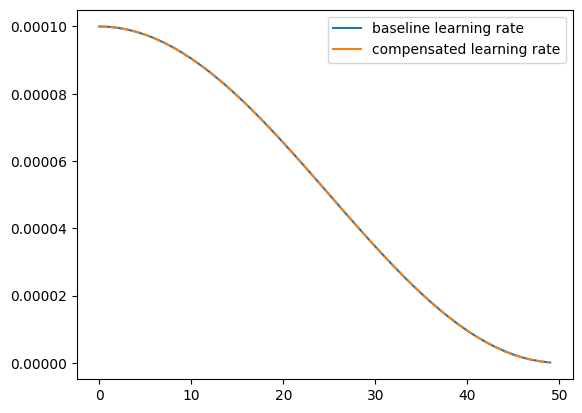

In [22]:
baseline = [item[0] for item in history_baseline[history_baseline["batch"] != 0].groupby("epoch").mean()[["learning rate"]].values]
compensated = [item[0] for item in history_compensated[history_compensated["batch"] != 0].groupby("epoch").mean()[["learning rate"]].values]
history_compare = pd.DataFrame({
    "baseline learning rate" : baseline,
    "compensated learning rate" : compensated,
})
ax = history_compare.plot()
ax.lines[history_compare.columns.get_loc("compensated learning rate")].set_linestyle("--")
plt.show()

<Axes: xlabel='epoch'>

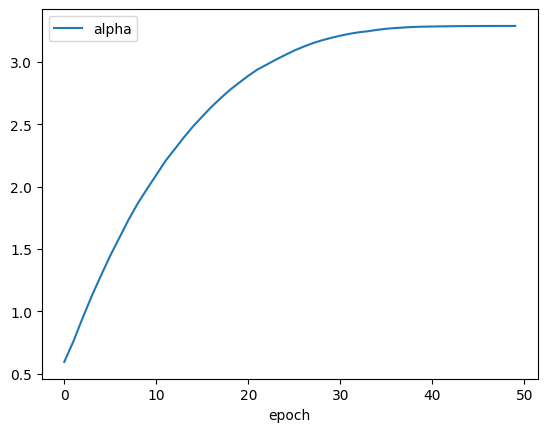

In [104]:
history_compensated[history_compensated["batch"] != 0].groupby("epoch").mean()[["alpha"]].plot()

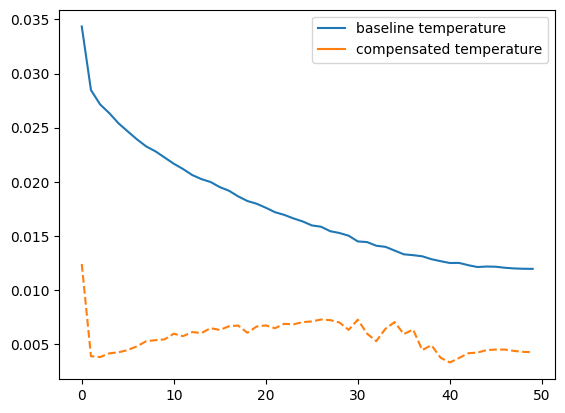

In [23]:
baseline = [item[0] for item in history_baseline[history_baseline["batch"] != 0].groupby("epoch").mean()[["temperature"]].values]
compensated = [item[0] for item in history_compensated[history_compensated["batch"] != 0].groupby("epoch").mean()[["temperature"]].values]
history_compare = pd.DataFrame({
    "baseline temperature" : baseline,
    "compensated temperature" : compensated,
})
ax = history_compare.plot()
ax.lines[history_compare.columns.get_loc("compensated temperature")].set_linestyle("--")
plt.show()

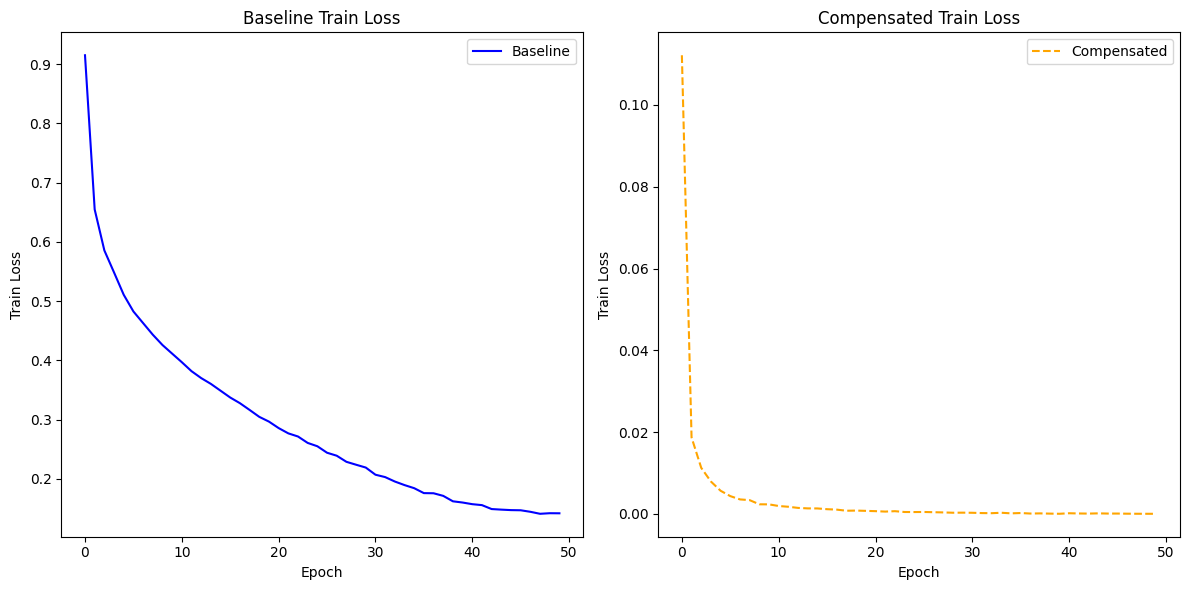

In [28]:
baseline = [item[0] for item in history_baseline[history_baseline["batch"] != 0].groupby("epoch").mean()[["train_loss"]].values]
compensated = [item[0] for item in history_compensated[history_compensated["batch"] != 0].groupby("epoch").mean()[["train_loss"]].values]

history_compare = pd.DataFrame({
    "baseline train_loss": baseline,
    "compensated train_loss": compensated,
})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # sharey nincs beállítva

axes[0].plot(history_compare.index, history_compare["baseline train_loss"], label="Baseline", linestyle="-", color="blue")
axes[0].set_title("Baseline Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")
axes[0].legend()

axes[1].plot(history_compare.index, history_compare["compensated train_loss"], label="Compensated", linestyle="--", color="orange")
axes[1].set_title("Compensated Train Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Train Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

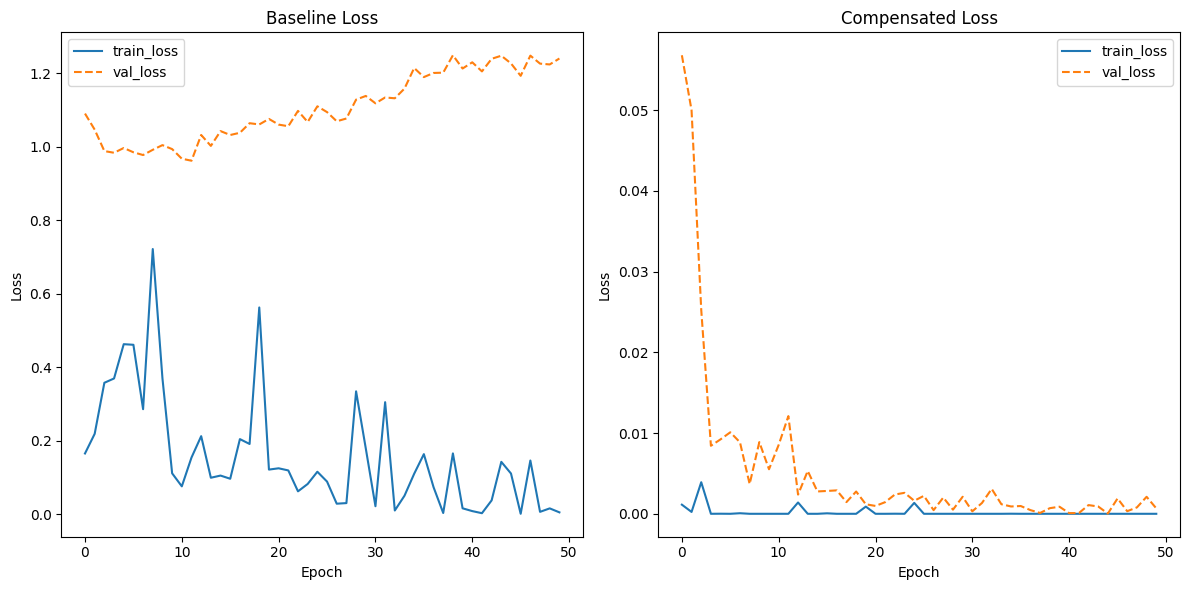

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
history_baseline[history_baseline["batch"] == 0].groupby("epoch").mean()[["train_loss", "val_loss"]].plot(
    ax=axes[0], title="Baseline Loss", xlabel="Epoch", ylabel="Loss", style=["-", "--"]
)
history_compensated[history_compensated["batch"] == 0].groupby("epoch").mean()[["train_loss", "val_loss"]].plot(
    ax=axes[1], title="Compensated Loss", xlabel="Epoch", ylabel="Loss", style=["-", "--"]
)
plt.tight_layout()
plt.show()

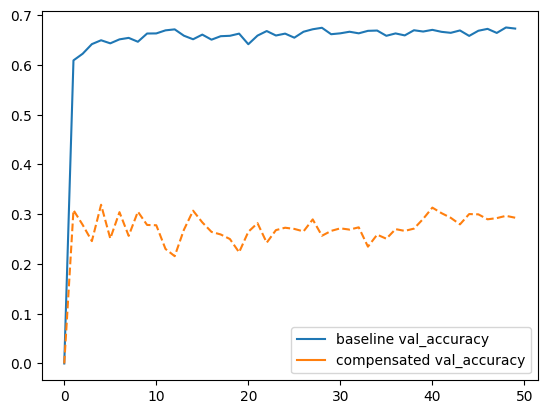

In [31]:
baseline = [item[0] for item in history_baseline[history_baseline["batch"] != 0].groupby("epoch").mean()[["val_accuracy"]].values]
compensated = [item[0] for item in history_compensated[history_compensated["batch"] != 0].groupby("epoch").mean()[["val_accuracy"]].values]
history_compare = pd.DataFrame({
    "baseline val_accuracy" : baseline,
    "compensated val_accuracy" : compensated,
})
ax = history_compare.plot()
ax.lines[history_compare.columns.get_loc("compensated val_accuracy")].set_linestyle("--")
plt.show()

In [42]:
minidx_b = history_baseline[history_baseline["batch"] == 0]["val_loss"].argmin()
minidx_c = history_compensated[history_compensated["batch"] == 0]["val_loss"].argmin()

summary_df = pd.concat([history_baseline[history_baseline["batch"] == 0].iloc[minidx_b], history_compensated[history_baseline["batch"] == 0].iloc[minidx_c]],
                       axis=1)
summary_df.columns = ["Baseline", "Compensated"]
summary_df

,Baseline,Compensated
train_loss,0.154100,0.000000
val_loss,0.961552,0.000029
val_accuracy,0.671178,0.299562
temperature,0.021284,0.004451
alpha,0.000000,3.288065
batch,0.000000,0.000000
learning rate,0.000089,0.000004
epoch,11.000000,44.000000


## Eval

In [48]:
model_baseline = CLIPModel(image_encoder_dim=2048, text_encoder_dim=768, output_dim=512)
model_baseline = model_baseline.to("cuda")

checkpoint = torch.load("models/baseline/model.pth", weights_only=False)

model_baseline.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(list(model_baseline.parameters()) + list(CLIPLoss().parameters()), lr=1e-4, weight_decay=1e-6)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model_baseline.eval()
print("Model loaded successfully!")

2048 768 512
Model loaded successfully!


In [87]:
model_compensated = CLIPModel(image_encoder_dim=2048, text_encoder_dim=768, output_dim=512)
model_compensated = model_compensated.to("cuda")

checkpoint = torch.load("models/compensated/model.pth", weights_only=False)

model_compensated.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(list(model_compensated.parameters()) + list(CLIPLossWithCompensation().parameters()), lr=1e-4, weight_decay=1e-6)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model_compensated.eval()
print("Model loaded successfully!")

2048 768 512
Model loaded successfully!


### Image-to-Text Retrieval / Text-to-Image Retrieval - Flickr30k:
### Recall@1, Recall@5, Recall@10, Median Rank.

In [88]:
flickr30k_target_dir = "data/flickr30k"
flickr30k_target_dir

'data/flickr30k'

In [89]:
with open(f"{flickr30k_target_dir}/embs/flickr30k_images.pkl", "rb") as f:
    flickr30k_images = pickle.load(f)

with open(f"{flickr30k_target_dir}/embs/flickr30k_captions.pkl", "rb") as f:
    flickr30k_captions = pickle.load(f)

In [90]:
image_matrix = torch.stack([flickr30k_images[key] for key in list(flickr30k_images.keys())])
caption_matrix = torch.stack([flickr30k_captions[key]["emb"] for key in list(flickr30k_captions.keys())])
image_matrix.shape, caption_matrix.shape

(torch.Size([31783, 2048]), torch.Size([158915, 768]))

In [56]:
image_encoded_baseline = model_baseline.encode_image(image_matrix.clone().detach().to("cuda"))
caption_encoded_baseline = model_baseline.encode_text(caption_matrix.clone().detach().to("cuda"))

image_encoded_baseline.shape, caption_encoded_baseline.shape

(torch.Size([31783, 512]), torch.Size([158915, 512]))

In [91]:
image_encoded_compensated = model_compensated.encode_image(image_matrix.clone().detach().to("cuda"))
caption_encoded_compensated = model_compensated.encode_text(caption_matrix.clone().detach().to("cuda"))

image_encoded_compensated.shape, caption_encoded_compensated.shape

(torch.Size([31783, 512]), torch.Size([158915, 512]))

In [92]:
tmp_mapping = { keyI:[] for keyI in tqdm(list(flickr30k_images.keys()))}
for keyC in tqdm(list(flickr30k_captions.keys())):
    image_name = flickr30k_captions[keyC]["image_name"]
    tmp_mapping[image_name].append(keyC)

image_to_caption_mapping = {}
for idx, key in tqdm(enumerate(list(tmp_mapping.keys()))):
    image_to_caption_mapping[idx] = tmp_mapping[key]

100% 31783/31783 [00:00<00:00, 2206056.20it/s]
100% 158915/158915 [00:00<00:00, 1434133.28it/s]
31783it [00:00, 1787419.91it/s]


In [62]:
filckr30k_baseline = calculate_metrics(image_encoded_baseline.cpu().detach().numpy(), caption_encoded_baseline.cpu().detach().numpy(), image_to_caption_mapping)
filckr30k_baseline

Calculate lens
Calculate similarity matrix


100% 31783/31783 [03:07<00:00, 169.72it/s]
100% 158915/158915 [34:41<00:00, 76.36it/s]


{'Image-to-Text Recall@1': np.float64(0.0020451184595538497),
 'Image-to-Text Recall@5': np.float64(0.008117547116382972),
 'Image-to-Text Recall@10': np.float64(0.013837586130950508),
 'Image-to-Text Median Rank': np.float64(3049.0),
 'Text-to-Image Recall@1': np.float64(0.008067205738917031),
 'Text-to-Image Recall@5': np.float64(0.029135072208413302),
 'Text-to-Image Recall@10': np.float64(0.047855771953560076),
 'Text-to-Image Median Rank': np.float64(624.0)}

In [94]:
filckr30k_compensated = calculate_metrics(image_encoded_compensated.cpu().detach().numpy(), caption_encoded_compensated.cpu().detach().numpy(), image_to_caption_mapping)
filckr30k_compensated

Calculate lens
Calculate similarity matrix


100% 31783/31783 [03:06<00:00, 170.85it/s]
100% 158915/158915 [40:03<00:00, 66.12it/s]


{'Image-to-Text Recall@1': np.float64(8.80974105653966e-05),
 'Image-to-Text Recall@5': np.float64(0.0005663404964918353),
 'Image-to-Text Recall@10': np.float64(0.0011138029764339427),
 'Image-to-Text Median Rank': np.float64(22555.0),
 'Text-to-Image Recall@1': np.float64(0.0006418525626907466),
 'Text-to-Image Recall@5': np.float64(0.0031022873863386087),
 'Text-to-Image Recall@10': np.float64(0.00563194160400214),
 'Text-to-Image Median Rank': np.float64(4577.0)}

### Zero-Shot - CIFAR

In [63]:
cifar_target_dir = "data/cifar"
cifar_target_dir

'data/cifar'

In [64]:
with open(f"{cifar_target_dir}/embs/cifar10_images.pkl", "rb") as f:
    cifar10_images = pickle.load(f)

with open(f"{cifar_target_dir}/embs/cifar10_captions.pkl", "rb") as f:
    cifar10_captions = pickle.load(f)
    
with open(f"{cifar_target_dir}/embs/cifar100_images.pkl", "rb") as f:
    cifar100_images = pickle.load(f)
    
with open(f"{cifar_target_dir}/embs/cifar100_captions.pkl", "rb") as f:
    cifar100_captions = pickle.load(f)

In [72]:
labels_10 = [cifar10_images[key]["label"] for key in list(cifar10_images.keys())]
labels_100 = [cifar10_images[key]["label"] for key in list(cifar100_images.keys())]
len(labels_10), len(labels_100)

(10000, 10000)

In [74]:
cifar10_similarity_matrix_baseline = calc_similarity_matrix(cifar10_images, cifar10_captions, model_baseline)
cifar10_similarity_matrix_compensated = calc_similarity_matrix(cifar10_images, cifar10_captions, model_compensated)
cifar100_similarity_matrix_baseline = calc_similarity_matrix(cifar100_images, cifar100_captions, model_baseline)
cifar100_similarity_matrix_compensated = calc_similarity_matrix(cifar100_images, cifar100_captions, model_compensated)

100% 10000/10000 [00:33<00:00, 300.16it/s]
100% 10000/10000 [00:33<00:00, 301.45it/s]
100% 10000/10000 [05:27<00:00, 30.51it/s]
100% 10000/10000 [05:27<00:00, 30.53it/s]


In [77]:
results = pd.concat([calc_top_k_accuracy_score(labels_10, cifar10_similarity_matrix_baseline),
                     calc_top_k_accuracy_score(labels_100, cifar100_similarity_matrix_baseline),
                     calc_top_k_accuracy_score(labels_10, cifar10_similarity_matrix_compensated),
                     calc_top_k_accuracy_score(labels_100, cifar100_similarity_matrix_compensated)])
results = results.T
results.columns = ["Baseline cifar 10","Baseline cifar 100","Compensated cifar 10","Compensated cifar 100"]
results

,Baseline cifar 10,Baseline cifar 100,Compensated cifar 10,Compensated cifar 100
top_1_accuracy,0.4999,0.0069,0.2603,0.0138
top_3_accuracy,0.7781,0.0249,0.5089,0.0427
top_5_accuracy,0.8915,0.0468,0.6826,0.0678


### Cosine similarity matrix

In [102]:
# Example usage
input_directory = "results/compensated"  # Replace with your JPG folder path
output_gif_path = "results/comparisons/compensated_anime.gif"  # Replace with your desired output GIF path
create_gif(input_directory, output_gif_path, duration=500)

Animated GIF created: results/comparisons/compensated_anime.gif


In [103]:
# Example usage
input_directory = "results/baseline"  # Replace with your JPG folder path
output_gif_path = "results/comparisons/baseline_anime.gif"  # Replace with your desired output GIF path
create_gif(input_directory, output_gif_path, duration=500)

Animated GIF created: results/comparisons/baseline_anime.gif
